Regularized Abel Inversion
==========================

This example demonstrates a TV-regularized Abel inversion using
an Abel projector based on PyAbel <cite data-cite="pyabel-2022"/>

In [1]:
# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install git+https://github.com/lanl/scico

import numpy as np

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.examples import create_circular_phantom
from scico.linop.abel import AbelProjector
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 256  # phantom size
x_gt = create_circular_phantom((N, N), [0.4 * N, 0.2 * N, 0.1 * N], [1, 0, 0.5])

Set up the forward operator and create a test measurement

In [3]:
A = AbelProjector(x_gt.shape)
y = A @ x_gt
np.random.seed(12345)
y = y + np.random.normal(size=y.shape).astype(np.float32)
ATy = A.T @ y

Set up ADMM solver object.

In [4]:
λ = 1.9e1  # L1 norm regularization parameter
ρ = 4.9e1  # ADMM penalty parameter
maxiter = 100  # number of ADMM iterations
cg_tol = 1e-4  # CG relative tolerance
cg_maxiter = 25  # maximum CG iterations per ADMM iteration

# Note the use of anisotropic TV. Isotropic TV would require use of L21Norm.
g = λ * functional.L1Norm()
C = linop.FiniteDifference(input_shape=x_gt.shape)

f = loss.SquaredL2Loss(y=y, A=A)

x_inv = A.inverse(y)
x0 = snp.clip(x_inv, 0, 1.0)

solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=x0,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": cg_tol, "maxiter": cg_maxiter}),
    itstat_options={"display": True, "period": 5},
)

Run the solver.

In [5]:
print(f"Solving on {device_info()}\n")
solver.solve()
hist = solver.itstat_object.history(transpose=True)
x_tv = snp.clip(solver.x, 0, 1.0)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  2.21e+00  2.981e+04  4.351e+01  8.984e+01     18  8.215e-05
   5  3.03e+00  4.903e+04  3.615e+00  3.084e+00      6  8.568e-05
  10  3.10e+00  5.163e+04  2.256e+00  2.961e-01      0  8.862e-05


  15  3.16e+00  5.270e+04  1.827e+00  2.343e-01      0  9.233e-05
  20  3.20e+00  5.384e+04  1.342e+00  1.437e-01      0  9.638e-05
  25  3.26e+00  5.465e+04  1.298e+00  1.254e-01      0  8.152e-05
  30  3.30e+00  5.473e+04  9.734e-01  9.136e-02      0  7.869e-05


  35  3.34e+00  5.523e+04  9.815e-01  9.520e-02      0  7.356e-05
  40  3.37e+00  5.533e+04  8.162e-01  7.522e-02      0  8.973e-05
  45  3.42e+00  5.540e+04  6.579e-01  7.086e-02      0  6.581e-05
  50  3.46e+00  5.547e+04  6.453e-01  6.685e-02      0  9.255e-05
  55  3.50e+00  5.577e+04  5.280e-01  4.437e-02      0  9.502e-05


  60  3.55e+00  5.579e+04  5.083e-01  4.792e-02      0  9.002e-05
  65  3.59e+00  5.589e+04  4.606e-01  3.889e-02      0  9.506e-05
  70  3.64e+00  5.647e+04  8.926e-01  4.423e-02      0  9.230e-05
  75  3.68e+00  5.631e+04  6.494e-01  5.729e-02      0  9.504e-05
  80  3.73e+00  5.609e+04  1.032e+00  1.632e-01      0  9.388e-05


  85  3.78e+00  5.635e+04  1.250e+00  1.257e-01      0  7.882e-05
  90  3.83e+00  5.626e+04  7.305e-01  6.695e-02      0  6.724e-05
  95  3.89e+00  5.619e+04  1.042e+00  3.707e-01      3  8.222e-05
  99  3.93e+00  5.644e+04  9.261e-01  4.974e-02      0  6.591e-05


Show results.

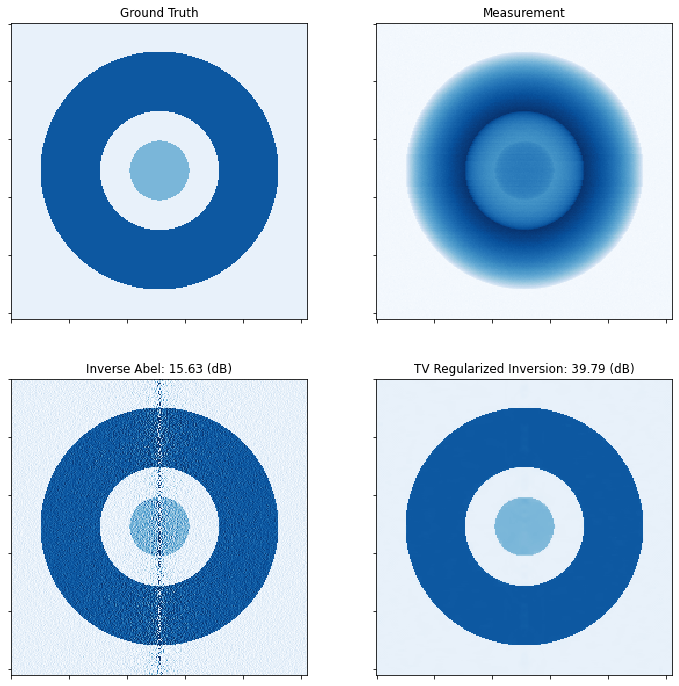

In [6]:
norm = plot.matplotlib.colors.Normalize(vmin=-0.1, vmax=1.2)
fig, ax = plot.subplots(nrows=2, ncols=2, figsize=(12, 12))
plot.imview(x_gt, title="Ground Truth", cmap=plot.cm.Blues, fig=fig, ax=ax[0, 0], norm=norm)
plot.imview(y, title="Measurement", cmap=plot.cm.Blues, fig=fig, ax=ax[0, 1])
plot.imview(
    x_inv,
    title="Inverse Abel: %.2f (dB)" % metric.psnr(x_gt, x_inv),
    cmap=plot.cm.Blues,
    fig=fig,
    ax=ax[1, 0],
    norm=norm,
)
plot.imview(
    x_tv,
    title="TV Regularized Inversion: %.2f (dB)" % metric.psnr(x_gt, x_tv),
    cmap=plot.cm.Blues,
    fig=fig,
    ax=ax[1, 1],
    norm=norm,
)
fig.show()